In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from distancia import haversine

Distancia: 1.683 km


In [3]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [4]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [5]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Limpieza de los datos

Podemos observar a traves del 'df.info' que tenemos 200.000 datos donde las columnas 'dropoff_longitude' y 'dropoff_latitude' poseen un valor faltante en sus datos. Consideramos que al tener una muestra de datos abundante, decidimos eliminarlos del dataset ya que no afecta al entrenamiento del modelo y evitar imputar los datos con un valor promedio. Además, modificamos el tipo de dato de 'pickup_datetime' para verificar que todas las fechas ingresadas hayan sido correctamente cargadas.

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])                   # Cambia el tipo de dato object -> datetime
df.dropna(inplace=True)                                                         # Elimina las filas con valores nulos

Observamos que la variable 'passenger_count' tiene un valor atípico en 208 y 709 datos con 0 pasajeros. Decidimos modificar estos datos por el valor promedio para mantener la información del resto de columnas.

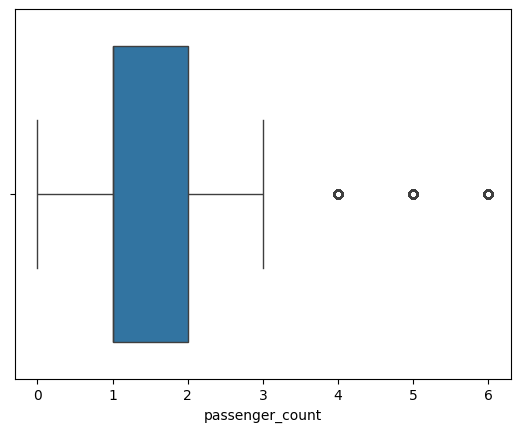

In [11]:
sns.boxplot(x =df[df['passenger_count'] < 208]['passenger_count']) # cambiar el valor del dato 208
plt.show()

tenemos 1 nulo en dropoff_longitude y dropoff_latitude

In [7]:
# Agregar mas caraterísticas a partir de las coordenadas geográficas
df["delta_lat"] = df["dropoff_latitude"] - df["pickup_latitude"]
df["delta_lon"] = df["dropoff_longitude"] - df["pickup_longitude"]

df["distance_km"] = df.apply(
    lambda row: haversine(
        row["pickup_longitude"], row["pickup_latitude"],
        row["dropoff_longitude"], row["dropoff_latitude"]
    ),
    axis=1
)
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,-0.015137,0.000305,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0.022100,-0.000355,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,0.031877,0.042478,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0.012505,0.010808,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,0.017162,-0.048059,4.475450


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [9]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,delta_lat,delta_lon,distance_km
count,1.600000e+05,160000.000000,160000.000000,159999.000000,159999.000000,160000.000000,159999.000000,159999.000000,159999.000000
mean,2.771233e+07,-72.525896,39.936265,-72.525260,39.919258,1.684988,-0.017002,0.000627,20.591193
std,1.603218e+07,11.557753,8.090121,13.611271,6.880320,1.405686,6.166397,7.579727,380.549053
min,1.000000e+00,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,-2174.001641,-2016.017890,0.000000
25%,1.379326e+07,-73.992062,40.734842,-73.991433,40.733835,1.000000,-0.013851,-0.011303,1.217936
50%,2.775608e+07,-73.981834,40.752594,-73.980080,40.753044,1.000000,0.000000,0.000499,2.125300
75%,4.155845e+07,-73.967212,40.767116,-73.963614,40.768055,2.000000,0.014001,0.013674,3.874418
max,5.542357e+07,57.418457,1644.421482,1153.572603,872.697628,208.000000,41.453693,1096.154146,16409.239135


In [10]:
y_train.describe()

count    160000.000000
mean         11.351493
std           9.796726
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         350.000000
Name: fare_amount, dtype: float64